In [1]:
%load_ext autoreload
%autoreload 

In [2]:
import jupyros as jr
import rospy
import numpy as np
from sensor_msgs import msg
import cv2
import cv_bridge
from copy import deepcopy
import ipywidgets as widgets
import PIL.Image
from cStringIO import StringIO
import matplotlib.pyplot as plt
import dvrk
import PyKDL
import tf
import time
from tf_conversions import posemath
import utils

In [3]:
rospy.init_node('notebook')
rospy.get_published_topics()

[['/dvrk/setup_joint/robot_state', 'std_msgs/String'],
 ['/dvrk/PSM1/current_state', 'std_msgs/String'],
 ['/dvrk/ECM/wrench_body_current', 'geometry_msgs/WrenchStamped'],
 ['/dvrk/PSM2/position_cartesian_local_current', 'geometry_msgs/PoseStamped'],
 ['/dvrk/console/teleop/teleop_psm_selected', 'diagnostic_msgs/KeyValue'],
 ['/dvrk/PSM2/joint_velocity_ratio', 'std_msgs/Float64'],
 ['/dvrk/ECM/state_joint_desired', 'sensor_msgs/JointState'],
 ['/dvrk/console/teleop/teleop_psm_unselected', 'diagnostic_msgs/KeyValue'],
 ['/dvrk/PSM2/position_cartesian_desired', 'geometry_msgs/PoseStamped'],
 ['/dvrk/ECM/position_cartesian_local_current', 'geometry_msgs/PoseStamped'],
 ['/dvrk/PSM1/status', 'std_msgs/String'],
 ['/dvrk/console/teleop/scale', 'std_msgs/Float32'],
 ['/dvrk/tf_broadcast/period_statistics', 'cisst_msgs/mtsIntervalStatistics'],
 ['/dvrk/PSM1/joint_velocity_ratio', 'std_msgs/Float64'],
 ['/dvrk/PSM1/desired_state', 'std_msgs/String'],
 ['/dvrk/ECM/position_cartesian_current', '

In [4]:
bridge = cv_bridge.CvBridge()
left_image = None
left_image_msg = None
left_camera_info = None

right_image = None
right_image_msg = None
right_camera_info = None

def left_image_callback(im_msg):
    global left_image, left_image_msg
    left_image = bridge.imgmsg_to_cv2(im_msg, desired_encoding='rgb8')
    left_image_msg = im_msg
    
def right_image_callback(im_msg):
    global right_image, right_image_msg
    right_image = bridge.imgmsg_to_cv2(im_msg, desired_encoding='rgb8')
    right_image_msg = im_msg
    
def left_camera_info_callback(camera_info_msg):
    global left_camera_info
    left_camera_info = camera_info_msg
    
def right_camera_info_callback(camera_info_msg):
    global right_camera_info
    right_camera_info = camera_info_msg
    
jr.subscribe('/stereo/left/image_raw', msg.Image, left_image_callback)
jr.subscribe('/stereo/left/camera_info', msg.CameraInfo, left_camera_info_callback)
jr.subscribe('/stereo/right/image_raw', msg.Image, right_image_callback)
jr.subscribe('/stereo/right/camera_info', msg.CameraInfo, right_camera_info_callback)

while left_image is None or right_image is None:
    print("left or right image not receieved")
    time.sleep(0.5)
    

left or right image not receieved


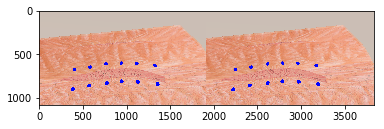

In [5]:
plt.imshow(np.hstack((left_image, right_image)))

In [6]:
tf_listener = tf.TransformListener()
time.sleep(1)
tf_listener.getFrameStrings()

/opt/ros/melodic/lib/python2.7/dist-packages/tf/listener.py:97: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(self._buffer.all_frames_as_yaml()) or {}


['ECM_RCM',
 'PSM1_clip',
 'ECM',
 'PSM2_base',
 'simcamera',
 'PSM1_RCM',
 'PSM1_base',
 'PSM2_RCM',
 'PSM1',
 'PSM2',
 'ECM_base',
 'PSM2_clip']

In [7]:
psm1 = dvrk.psm('PSM1')
psm2 = dvrk.psm('PSM2')
ecm = dvrk.ecm('ECM')
while ecm.get_current_position() == PyKDL.Frame() or ecm.get_desired_position() == PyKDL.Frame():
    time.sleep(0.5)
while psm1.get_current_position() == PyKDL.Frame() or psm1.get_desired_position() == PyKDL.Frame():
    time.sleep(0.5)

In [8]:
# ECM_STARTING_JOINT_POS = np.asarray([-0.15669435,  0.17855662,  0.07069676,  0.17411496])
# ECM_STARTING_JOINT_POS = np.asarray([0.0615668 , 0.0523214 , 0.04854392, 0.15809197])
# ECM_STARTING_JOINT_POS = np.asarray([-0.14478268, -0.1293848 ,  0.00261061,  0.043541  ])
ECM_STARTING_JOINT_POS = np.asarray([0, 0 ,  0.05,  0.043541  ])
ecm.move_joint(ECM_STARTING_JOINT_POS)

True

In [9]:
time.sleep(1)
PSM_HOME_POS = np.asarray([0., 0., 0.05, 0., 0., 0.])
psm1.move_joint(PSM_HOME_POS)
psm1.close_jaw()

psm2.move_joint(PSM_HOME_POS)
psm2.close_jaw()

True

[ 0.03685897 -0.02320513  0.10665311]
[    0.036859,  -0.0232051,    0.106653]
[ 0.02512987 -0.02058442  0.10803822]
[   0.0251299,  -0.0205844,    0.108038]
[-0.02551282 -0.01929487  0.10665311]
[  -0.0255128,  -0.0192949,    0.106653]
[ 0.01188312 -0.01876623  0.10803822]
[   0.0118831,  -0.0187662,    0.108038]
[-0.01123377 -0.01779221  0.10803822]
[  -0.0112338,  -0.0177922,    0.108038]
[ 0.00098684 -0.01769737  0.10945977]
[ 0.000986842,  -0.0176974,     0.10946]
[ 0.03847222 -0.009375    0.11554087]
[   0.0384722,   -0.009375,    0.115541]
[ 0.02625    -0.0075      0.11554087]
[     0.02625,     -0.0075,    0.115541]
[-0.02520548 -0.00616438  0.11395812]
[  -0.0252055, -0.00616438,    0.113958]
[ 0.01319444 -0.00493056  0.11554087]
[   0.0131944, -0.00493056,    0.115541]
[-0.01104167 -0.00465278  0.11554087]
[  -0.0110417, -0.00465278,    0.115541]
[ 0.00119718 -0.00443662  0.11716821]
[  0.00119718, -0.00443662,    0.117168]


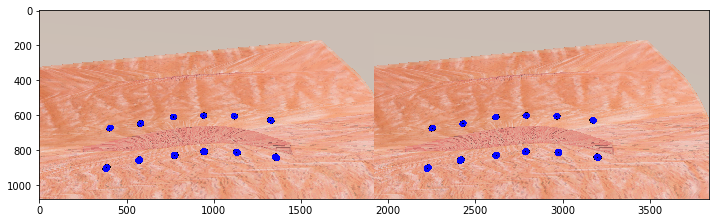

In [10]:
import image_geometry
utils = None
import utils
stereo_model = image_geometry.StereoCameraModel()
stereo_model.fromCameraInfo(left_camera_info, right_camera_info)

tf_cam_to_world = utils.tf_to_pykdl_frame(tf_listener.lookupTransform('simworld', 'simcamera', rospy.Time()))
tf_world_to_psm1 = \
    utils.tf_to_pykdl_frame(tf_listener.lookupTransform('PSM1_base', 'simworld', rospy.Time()))
tf_world_to_psm2 = \
    utils.tf_to_pykdl_frame(tf_listener.lookupTransform('PSM2_base', 'simworld', rospy.Time()))

objects, frame = utils.get_points_and_img(left_image_msg, right_image_msg, stereo_model, tf_cam_to_world)
plt.figure(figsize=(12, 5))
plt.imshow(frame)
for o in objects:
    o = PyKDL.Vector(o.x(), o.y(), o.z())
#     o = PyKDL.Vector(o.x(), o.y(), o.z())

In [11]:
len(objects)

12

In [12]:
# pair up points that are across from each other
# x is *more or less* the axis along the wound
paired_pts = []
while objects:
    pt = objects[0]
    objects.remove(pt)
#     pt2 = min(objects, key=lambda obj : abs(obj.x() - pt.x()))
    pt2 = min(objects, key=lambda obj : abs(obj.y() - pt.y()))
    objects.remove(pt2)
#     paired_pts.append(
#         (max(pt, pt2, key=lambda p: p.y()), min(pt, pt2, key=lambda p: p.y())))
    paired_pts.append(
        (max(pt, pt2, key=lambda p: p.x()), min(pt, pt2, key=lambda p: p.x())))
print(paired_pts[0][0][1])
print(paired_pts[1][0][1])
paired_pts = sorted(paired_pts,key=lambda p: float(p[0][1]))
print("paired points sorted:")
paired_pts

0.0453214693704
0.032998296038
paired points sorted:


[([    -1.51536,  -0.0183709,    0.668699],
  [    -1.53037,  -0.0175627,    0.668292]),
 ([    -1.51222, -0.00439262,    0.668364],
  [    -1.52732, -0.00346448,    0.668124]),
 ([     -1.5103,   0.0077594,    0.667295],
  [    -1.52561,  0.00868269,    0.667171]),
 ([    -1.51067,   0.0197937,    0.668661],
  [    -1.52645,   0.0196565,    0.668047]),
 ([    -1.51191,   0.0329983,    0.667589],
  [    -1.52703,   0.0329971,    0.667361]),
 ([    -1.51262,   0.0453215,    0.666856],
  [    -1.52912,   0.0449132,     0.66743])]

In [13]:
import suturing_state_machine
reload(suturing_state_machine)
reload(utils)

pts_psm1 = paired_pts[:3]
pts_psm2 = paired_pts[3:]
# pts_psm2 = []

# for sublist in (paired_pts[3:]):
#     pts_psm2.append(sublist[::-1])
    
print("pts_psm1:", pts_psm1)
print("pts_psm1:", pts_psm2)

sm1 = suturing_state_machine.SuturingStateMachine(psm1, tf_world_to_psm1, pts_psm1, arm_name = 'PSM1')  
sm2 = suturing_state_machine.SuturingStateMachine(psm2, tf_world_to_psm2, pts_psm2, arm_name = 'PSM2')

while not sm1.is_done() or not sm2.is_done():
    sm1.run_once()
    sm2.run_once()
    time.sleep(0.1)

('pts_psm1:', [([    -1.51536,  -0.0183709,    0.668699], [    -1.53037,  -0.0175627,    0.668292]), ([    -1.51222, -0.00439262,    0.668364], [    -1.52732, -0.00346448,    0.668124]), ([     -1.5103,   0.0077594,    0.667295], [    -1.52561,  0.00868269,    0.667171])])
('pts_psm1:', [([    -1.51067,   0.0197937,    0.668661], [    -1.52645,   0.0196565,    0.668047]), ([    -1.51191,   0.0329983,    0.667589], [    -1.52703,   0.0329971,    0.667361]), ([    -1.51262,   0.0453215,    0.666856], [    -1.52912,   0.0449132,     0.66743])])
[INFO] [1602512346.433698]: Executing state SuturingState.PREPARE_INSERTION
[INFO] [1602512346.445115]: Executing state SuturingState.PREPARE_INSERTION
[INFO] [1602512346.555460]: Distance from arm to dest: 0.14157782237
[INFO] [1602512346.557210]: Executing state SuturingState.PREPARE_INSERTION
[INFO] [1602512346.576319]: Distance from arm to dest: 0.142322483453
[INFO] [1602512346.578408]: Executing state SuturingState.PREPARE_INSERTION
[INFO] [1

[INFO] [1602512348.864724]: Moving to pose 2 out of 34
[INFO] [1602512348.973990]: Executing state SuturingState.INSERTION
[INFO] [1602512348.976863]: Moving to pose 1 out of 34
[INFO] [1602512348.994752]: Executing state SuturingState.INSERTION
[INFO] [1602512349.036684]: Moving to pose 3 out of 34
[INFO] [1602512349.158320]: Executing state SuturingState.INSERTION
[INFO] [1602512349.173916]: Moving to pose 2 out of 34
[INFO] [1602512349.236317]: Executing state SuturingState.INSERTION
[INFO] [1602512349.257667]: Moving to pose 4 out of 34
[INFO] [1602512349.379398]: Executing state SuturingState.INSERTION
[INFO] [1602512349.385309]: Moving to pose 3 out of 34
[INFO] [1602512349.386823]: Executing state SuturingState.INSERTION
[INFO] [1602512349.388058]: Moving to pose 5 out of 34
[INFO] [1602512349.489570]: Executing state SuturingState.INSERTION
[INFO] [1602512349.491343]: Moving to pose 4 out of 34
[INFO] [1602512349.500137]: Executing state SuturingState.INSERTION
[INFO] [16025123

[INFO] [1602512353.552240]: Executing state SuturingState.INSERTION
[INFO] [1602512353.563554]: Moving to pose 34 out of 34
[INFO] [1602512353.565127]: Executing state SuturingState.RELEASE_NEEDLE
[INFO] [1602512353.674356]: Executing state SuturingState.RELEASE_NEEDLE
[INFO] [1602512353.676405]: Executing state SuturingState.RELEASE_NEEDLE
[INFO] [1602512353.786026]: Executing state SuturingState.RELEASE_NEEDLE
[INFO] [1602512353.791867]: Executing state SuturingState.RELEASE_NEEDLE
[INFO] [1602512353.904624]: Executing state SuturingState.RELEASE_NEEDLE
[INFO] [1602512353.905966]: Executing state SuturingState.RELEASE_NEEDLE
[INFO] [1602512354.008623]: Executing state SuturingState.RELEASE_NEEDLE
[INFO] [1602512354.011944]: Executing state SuturingState.PREPARE_EXTRACTION
circle_center=[    -1.51896,   0.0277158,    0.676655], circle_radius=0.0117
[INFO] [1602512354.114385]: Executing state SuturingState.RELEASE_NEEDLE
[INFO] [1602512354.120378]: Distance from arm to dest: 0.02210535

[INFO] [1602512356.974567]: Executing state SuturingState.EXTRACTION
[INFO] [1602512356.985453]: Moving to pose 3 out of 24
[INFO] [1602512357.004335]: Executing state SuturingState.EXTRACTION
[INFO] [1602512357.013539]: Moving to pose 4 out of 29
[INFO] [1602512357.116941]: Executing state SuturingState.EXTRACTION
[INFO] [1602512357.124289]: Moving to pose 4 out of 24
[INFO] [1602512357.134782]: Executing state SuturingState.EXTRACTION
[INFO] [1602512357.137093]: Moving to pose 5 out of 29
[INFO] [1602512357.244218]: Executing state SuturingState.EXTRACTION
[INFO] [1602512357.246741]: Moving to pose 5 out of 24
[INFO] [1602512357.248769]: Executing state SuturingState.EXTRACTION
[INFO] [1602512357.255795]: Moving to pose 6 out of 29
[INFO] [1602512357.357757]: Executing state SuturingState.EXTRACTION
[INFO] [1602512357.365538]: Moving to pose 6 out of 24
[INFO] [1602512357.377615]: Executing state SuturingState.EXTRACTION
[INFO] [1602512357.380832]: Moving to pose 7 out of 29
[INFO] [

[INFO] [1602512361.609340]: Distance from arm to dest: 0.000308722428869
[INFO] [1602512361.618140]: Executing state SuturingState.GRASP_NEEDLE_2
[INFO] [1602512362.393324]: Distance from arm to dest: 1.23481608915e-15
[INFO] [1602512362.396251]: Executing state SuturingState.GRASP_NEEDLE_2
[INFO] [1602512363.231463]: Executing state SuturingState.HOME
[INFO] [1602512363.234469]: Executing state SuturingState.HOME
[INFO] [1602512363.337213]: Executing state SuturingState.HOME
[INFO] [1602512363.342419]: Executing state SuturingState.HOME
[INFO] [1602512363.445001]: Executing state SuturingState.HOME
[INFO] [1602512363.461370]: Executing state SuturingState.HOME
[INFO] [1602512363.568010]: Executing state SuturingState.HOME
[INFO] [1602512363.569769]: Executing state SuturingState.HOME
[INFO] [1602512363.681480]: Executing state SuturingState.HOME
[INFO] [1602512363.690003]: Executing state SuturingState.HOME
[INFO] [1602512363.791717]: Executing state SuturingState.HOME
[INFO] [1602512

[INFO] [1602512366.830791]: Executing state SuturingState.INSERTION
[INFO] [1602512366.853049]: Moving to pose 1 out of 34
[INFO] [1602512366.884180]: Executing state SuturingState.INSERTION
[INFO] [1602512366.892376]: Moving to pose 1 out of 34
[INFO] [1602512366.995177]: Executing state SuturingState.INSERTION
[INFO] [1602512367.003405]: Moving to pose 2 out of 34
[INFO] [1602512367.004811]: Executing state SuturingState.INSERTION
[INFO] [1602512367.011127]: Moving to pose 1 out of 34
[INFO] [1602512367.113114]: Executing state SuturingState.INSERTION
[INFO] [1602512367.116096]: Moving to pose 3 out of 34
[INFO] [1602512367.132836]: Executing state SuturingState.INSERTION
[INFO] [1602512367.143760]: Moving to pose 2 out of 34
[INFO] [1602512367.254935]: Executing state SuturingState.INSERTION
[INFO] [1602512367.256903]: Moving to pose 4 out of 34
[INFO] [1602512367.267500]: Executing state SuturingState.INSERTION
[INFO] [1602512367.276076]: Moving to pose 3 out of 34
[INFO] [16025123

[INFO] [1602512371.036808]: Executing state SuturingState.INSERTION
[INFO] [1602512371.039183]: Moving to pose 34 out of 34
[INFO] [1602512371.047951]: Executing state SuturingState.INSERTION
[INFO] [1602512371.050068]: Moving to pose 34 out of 34
[INFO] [1602512371.156419]: Executing state SuturingState.RELEASE_NEEDLE
[INFO] [1602512371.157965]: Executing state SuturingState.INSERTION
[INFO] [1602512371.159897]: Moving to pose 34 out of 34
[INFO] [1602512371.261681]: Executing state SuturingState.RELEASE_NEEDLE
[INFO] [1602512371.282752]: Executing state SuturingState.RELEASE_NEEDLE
[INFO] [1602512371.391002]: Executing state SuturingState.RELEASE_NEEDLE
[INFO] [1602512371.393162]: Executing state SuturingState.RELEASE_NEEDLE
[INFO] [1602512371.501765]: Executing state SuturingState.RELEASE_NEEDLE
[INFO] [1602512371.503311]: Executing state SuturingState.RELEASE_NEEDLE
[INFO] [1602512371.604894]: Executing state SuturingState.RELEASE_NEEDLE
[INFO] [1602512371.606080]: Executing state 

[INFO] [1602512374.629739]: Executing state SuturingState.EXTRACTION
[INFO] [1602512374.637565]: Moving to pose 4 out of 24
[INFO] [1602512374.645770]: Executing state SuturingState.EXTRACTION
[INFO] [1602512374.660987]: Moving to pose 4 out of 29
[INFO] [1602512374.768452]: Executing state SuturingState.EXTRACTION
[INFO] [1602512374.769759]: Moving to pose 5 out of 24
[INFO] [1602512374.770746]: Executing state SuturingState.EXTRACTION
[INFO] [1602512374.775878]: Moving to pose 5 out of 29
[INFO] [1602512374.878438]: Executing state SuturingState.EXTRACTION
[INFO] [1602512374.880461]: Moving to pose 6 out of 24
[INFO] [1602512374.881974]: Executing state SuturingState.EXTRACTION
[INFO] [1602512374.888077]: Moving to pose 6 out of 29
[INFO] [1602512374.990789]: Executing state SuturingState.EXTRACTION
[INFO] [1602512374.993264]: Moving to pose 7 out of 24
[INFO] [1602512375.001982]: Executing state SuturingState.EXTRACTION
[INFO] [1602512375.009459]: Moving to pose 7 out of 29
[INFO] [

[INFO] [1602512379.028402]: Executing state SuturingState.GRASP_NEEDLE_2
[INFO] [1602512379.664364]: Distance from arm to dest: 3.10428463092e-15
[INFO] [1602512379.665859]: Executing state SuturingState.GRASP_NEEDLE_2
[INFO] [1602512380.493340]: Executing state SuturingState.HOME
[INFO] [1602512380.497798]: Executing state SuturingState.HOME
[INFO] [1602512380.607933]: Executing state SuturingState.HOME
[INFO] [1602512380.617957]: Executing state SuturingState.HOME


[ERROR] [1602512380.507803]: bad callback: <bound method ecm.__state_joint_current_cb of <dvrk.ecm.ecm object at 0x7f315c455b90>>
Traceback (most recent call last):
  File "/opt/ros/melodic/lib/python2.7/dist-packages/rospy/topics.py", line 750, in _invoke_callback
    cb(msg)
  File "/home/parallels/dvrk_ws/src/dvrk-ros/dvrk_python/src/dvrk/arm.py", line 285, in __state_joint_current_cb
    self.__velocity_joint_current.resize(len(data.velocity))
ValueError: cannot resize an array that references or is referenced
by another array in this way.
Use the np.resize function or refcheck=False



[INFO] [1602512380.726187]: Executing state SuturingState.HOME
[INFO] [1602512380.730611]: Executing state SuturingState.HOME
[INFO] [1602512380.850480]: Executing state SuturingState.HOME
[INFO] [1602512380.857313]: Executing state SuturingState.HOME
[INFO] [1602512380.959707]: Executing state SuturingState.HOME
[INFO] [1602512380.968836]: Executing state SuturingState.HOME
[INFO] [1602512381.071520]: Executing state SuturingState.HOME
[INFO] [1602512381.074570]: Executing state SuturingState.HOME
[INFO] [1602512381.184659]: Executing state SuturingState.HOME
[INFO] [1602512381.192035]: Executing state SuturingState.HOME
[INFO] [1602512381.294106]: Executing state SuturingState.HOME
[INFO] [1602512381.303218]: Executing state SuturingState.HOME
[INFO] [1602512381.412869]: Executing state SuturingState.HOME
[INFO] [1602512381.415458]: Executing state SuturingState.HOME
[INFO] [1602512381.524542]: Executing state SuturingState.HOME
[INFO] [1602512381.527023]: Executing state SuturingSta

[ERROR] [1602512383.537910]: bad callback: <bound method psm.__state_joint_current_cb of <dvrk.psm.psm object at 0x7f315c49b590>>
Traceback (most recent call last):
  File "/opt/ros/melodic/lib/python2.7/dist-packages/rospy/topics.py", line 750, in _invoke_callback
    cb(msg)
  File "/home/parallels/dvrk_ws/src/dvrk-ros/dvrk_python/src/dvrk/arm.py", line 286, in __state_joint_current_cb
    self.__effort_joint_current.resize(len(data.effort))
ValueError: cannot resize an array that references or is referenced
by another array in this way.
Use the np.resize function or refcheck=False



[INFO] [1602512383.780947]: Distance from arm to dest: 0.00944835809662
[INFO] [1602512383.783975]: Executing state SuturingState.PREPARE_INSERTION
[INFO] [1602512383.801964]: Distance from arm to dest: 0.000847158220798
[INFO] [1602512383.811211]: Executing state SuturingState.INSERTION
circle_center=[    -1.52078,   0.0531172,    0.675697], circle_radius=0.0117
circle_center=[    -1.52078,   0.0531172,    0.675697], circle_radius=0.0117
circle_center=[    -1.52078,   0.0531172,    0.675697], circle_radius=0.0117
circle_center=[    -1.52078,   0.0531172,    0.675697], circle_radius=0.0117
circle_center=[    -1.52078,   0.0531172,    0.675697], circle_radius=0.0117
circle_center=[    -1.52078,   0.0531172,    0.675697], circle_radius=0.0117
circle_center=[    -1.52078,   0.0531172,    0.675697], circle_radius=0.0117
circle_center=[    -1.52078,   0.0531172,    0.675697], circle_radius=0.0117
circle_center=[    -1.52078,   0.0531172,    0.675697], circle_radius=0.0117
circle_center=[   

[INFO] [1602512385.480971]: Executing state SuturingState.INSERTION
[INFO] [1602512385.496716]: Moving to pose 10 out of 34
[INFO] [1602512385.503410]: Executing state SuturingState.INSERTION
[INFO] [1602512385.521034]: Moving to pose 12 out of 34
[INFO] [1602512385.624915]: Executing state SuturingState.INSERTION
[INFO] [1602512385.634231]: Moving to pose 11 out of 34
[INFO] [1602512385.643341]: Executing state SuturingState.INSERTION
[INFO] [1602512385.652173]: Moving to pose 13 out of 34
[INFO] [1602512385.775076]: Executing state SuturingState.INSERTION
[INFO] [1602512385.792510]: Moving to pose 12 out of 34
[INFO] [1602512385.795373]: Executing state SuturingState.INSERTION
[INFO] [1602512385.806479]: Moving to pose 14 out of 34
[INFO] [1602512385.911856]: Executing state SuturingState.INSERTION
[INFO] [1602512385.914336]: Moving to pose 13 out of 34
[INFO] [1602512385.915491]: Executing state SuturingState.INSERTION
[INFO] [1602512385.916603]: Moving to pose 15 out of 34
[INFO] [

[INFO] [1602512389.705314]: Distance from arm to dest: 0.0138112718006
[INFO] [1602512389.715129]: Executing state SuturingState.PREPARE_EXTRACTION
circle_center=[    -1.51851,  0.00024014,    0.676005], circle_radius=0.0117
[INFO] [1602512389.733741]: Distance from arm to dest: 0.00786216966888
[INFO] [1602512389.735185]: Executing state SuturingState.PREPARE_EXTRACTION
circle_center=[    -1.52078,   0.0531172,    0.675697], circle_radius=0.0117
[INFO] [1602512389.845642]: Distance from arm to dest: 0.0124028208959
[INFO] [1602512389.846791]: Executing state SuturingState.PREPARE_EXTRACTION
circle_center=[    -1.51851,  0.00024014,    0.676005], circle_radius=0.0117
[INFO] [1602512389.851311]: Distance from arm to dest: 0.00370751590356
[INFO] [1602512389.853150]: Executing state SuturingState.PREPARE_EXTRACTION
circle_center=[    -1.52078,   0.0531172,    0.675697], circle_radius=0.0117
[INFO] [1602512389.954763]: Distance from arm to dest: 0.010350033109
[INFO] [1602512389.956158]: 

[INFO] [1602512393.150300]: Executing state SuturingState.EXTRACTION
[INFO] [1602512393.153106]: Moving to pose 13 out of 24
[INFO] [1602512393.162383]: Executing state SuturingState.EXTRACTION
[INFO] [1602512393.171181]: Moving to pose 14 out of 29
[INFO] [1602512393.273425]: Executing state SuturingState.EXTRACTION
[INFO] [1602512393.282227]: Moving to pose 14 out of 24
[INFO] [1602512393.283647]: Executing state SuturingState.EXTRACTION
[INFO] [1602512393.290917]: Moving to pose 15 out of 29
[INFO] [1602512393.393174]: Executing state SuturingState.EXTRACTION
[INFO] [1602512393.395095]: Moving to pose 15 out of 24
[INFO] [1602512393.403000]: Executing state SuturingState.EXTRACTION
[INFO] [1602512393.404839]: Moving to pose 16 out of 29
[INFO] [1602512393.513584]: Executing state SuturingState.EXTRACTION
[INFO] [1602512393.516086]: Moving to pose 16 out of 24
[INFO] [1602512393.525681]: Executing state SuturingState.EXTRACTION
[INFO] [1602512393.532129]: Moving to pose 17 out of 29


[INFO] [1602512399.440658]: Executing state SuturingState.HOME
[INFO] [1602512399.457397]: Executing state SuturingState.HOME
[INFO] [1602512399.571826]: Executing state SuturingState.HOME
[INFO] [1602512399.580628]: Executing state SuturingState.HOME


In [14]:
dir(psm1)

['__class__',
 '__delattr__',
 '__dict__',
 '__doc__',
 '__format__',
 '__getattribute__',
 '__hash__',
 '__init__',
 '__module__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_arm__arm_current_state',
 '_arm__arm_current_state_cb',
 '_arm__arm_current_state_event',
 '_arm__arm_desired_state',
 '_arm__arm_desired_state_cb',
 '_arm__arm_name',
 '_arm__check_input_type',
 '_arm__dmove_frame',
 '_arm__dmove_rotation',
 '_arm__dmove_translation',
 '_arm__effort_joint_current',
 '_arm__effort_joint_desired',
 '_arm__full_ros_namespace',
 '_arm__goal_reached',
 '_arm__goal_reached_cb',
 '_arm__goal_reached_event',
 '_arm__init_arm',
 '_arm__jacobian_body',
 '_arm__jacobian_body_cb',
 '_arm__jacobian_spatial',
 '_arm__jacobian_spatial_cb',
 '_arm__move_cartesian_direct',
 '_arm__move_cartesian_goal',
 '_arm__move_frame',
 '_arm__move_joint',
 '_arm__move_joint_direct',
 '_arm__move_joint_goal',
 '_

In [15]:
ecm.get_current_joint_position()

array([0.      , 0.      , 0.05    , 0.043541])

In [16]:
psm2.close_jaw()

True